# Attention Mechanisms in Transformer Models

In this notebook, we first explore the key components of transformer model architecture, then apply a transformer model to classify habitability of exoplanets from LIFESim and analyse its performance.

## Transformer Model Architecture

A transformer model is a powerful neural network (NN) architecture commonly used in natural language processing.

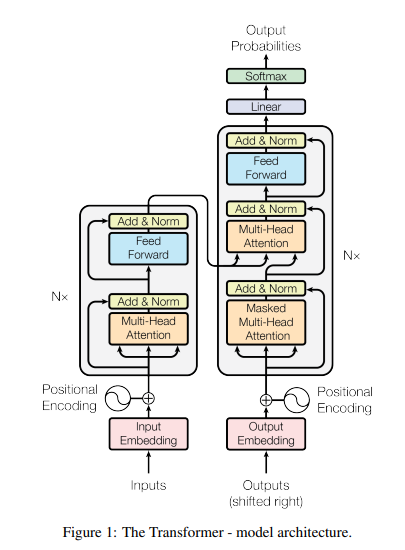

Left (input) - **encoder** - the encoder's role is to process the input sequence and generate a high-dimensional representation that captures the essential information and relationships within the input. The encoder is composed of multiple layers, each of which has two main sub-layers:
- **the multi-head self-attention mechanism:** which allows each position in the input sequence to attend to all other positions, helping capture dependancies between words regardless of their distance in the sequence. It produces a set of attention scores that are used to weigh the input features accordingly.
- **the position-wise feed-forward networks:** after the self-attention mechanism, each position in the sequence is passed through a feed-forward neural network. This network applies non-linear transformations to the input, enhancing the model's capacity to capture complex patterns.
- **add & norm:** each sub-layer is followed by a residual connection and layer normalization, which help stabilize and speed up training.

Right (output) - **decoder** - the decoder's role is to generate the output sequence, one element at a time, using the encoded representations from the Encover and previously generated outputs. The decoder is also composed of multiple layers, each containing three main sub-layers:
- **masked multi-head self-attention mechanism:** similar to the encover, but it masks future positions to prevent the decoder from attending to them. This ensures that the prediction for a particular position depends only on the known outputs before it.
- **multi-head attention mechanism:** this mechanism attends to the encoder's output, allowing the decoder to use the context provided by the encoder's representation to generate the next element in the sequence.
- **position-wise feed-forward network:** similar to the encoder, each position in the sequence is passed through a feed-forward network.
- **add & norm:** each sub-layer is followed by a residual connection and layer normalization.

The core components making up a transformer model are:

### 1. Self-Attention Mechanism

The self-attention mechanism allows the model to focus on different parts of the input sequence when encoding each element, making it easier to capture dependencies regardless of their distance in the sequence.

There are 3 trainable weight matrices that are multiplied with the input sequence embeddings ($x_i$):
- query = $W^q x_i$
- key = $W^k x_i$
- value = $W^v x_i$

#### Scaled Dot-Product Attention

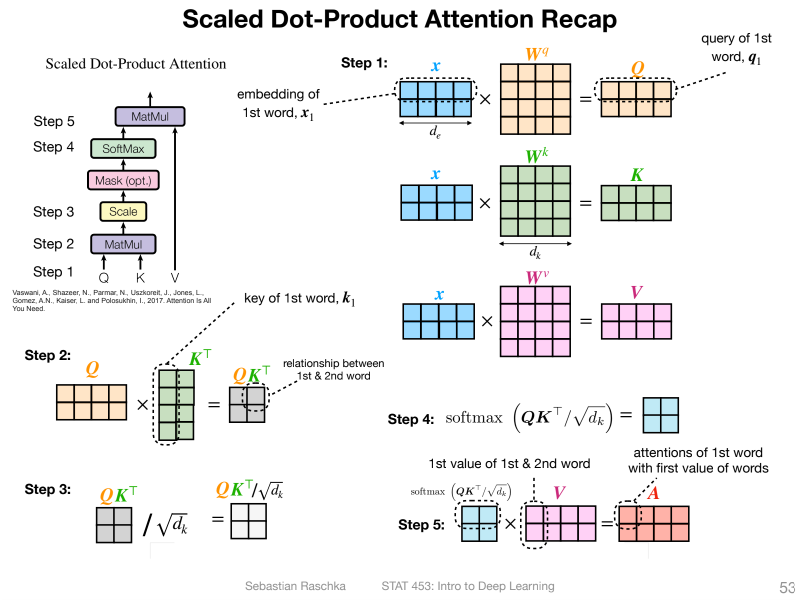
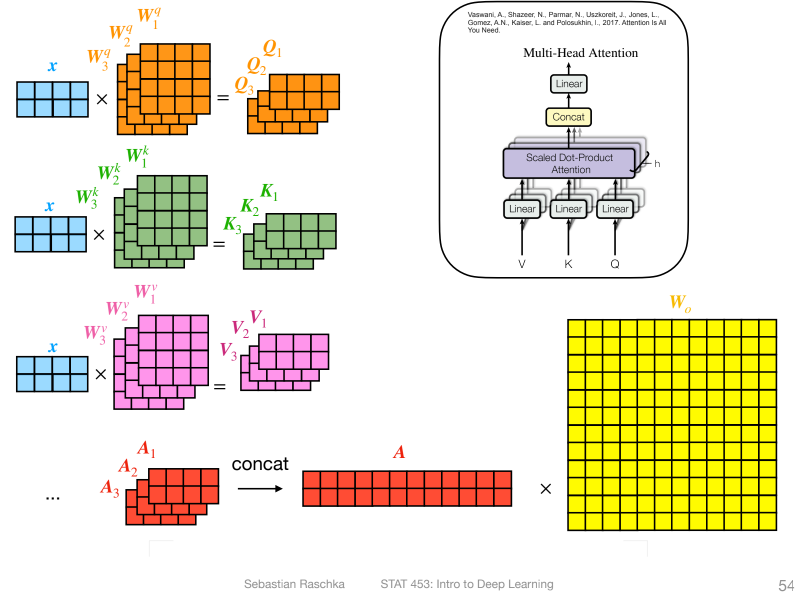

### 2. Positional Encoding

Positional encoding provides information about the position of each token in the sequence since the self-attention mechanism is permutation-invariant.

### 3. Multi-Head Attention

Multi-head attention extends the self-attention mechnaism by running multiple attention layers (heads) in parallel, allowing the model to focus on different parts of the sequence simultaneously. Each head/self-attention layer $i$ uses a different $W^q_{(i)}, W^k_{(i)}, W^v_{(i)}$, then concatenates the results $A_{(i)}$.

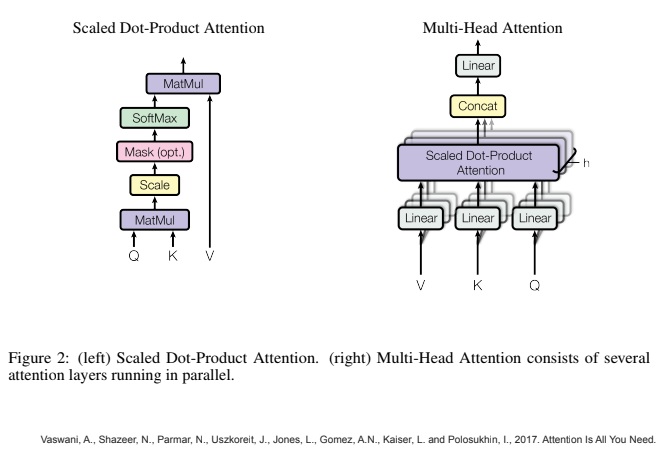

### 4. Feed-Forward Networks

Feed-forward networks are applied independently to each position, providing non-linear transformations to the inputs.

### 5. Normalization Layers

Normalization layers are applied after the attention and feed-forward layers to stabilize and speed up training.

### 6. Dropout

Dropout is used to prevent overfitting by randomly setting some of the activations to zero during training.

## Transformer Model Code

In [2]:
#importing the necessary packages
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Multi-head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    # scaled dot product attention
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [4]:
# Feed forward network
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [5]:
# Positional Encoder
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [6]:
# (input) encoder
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads) # self-attention mechanism
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff) # feed-forward neural network
        # create layer normalization layers (2)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) # for regularization

    # apply the self-attention mechanism, the the feed-forward network, each followed by normalization and dropout
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
# (output) decoder
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads) # masked self-attention mechanism for the decoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads) # attention mechanism that attends to the encoder's output
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff) # feed-forward neural network
        # create layer normalization layers (3)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) # dropout for regularization

    # applies the masked self-attention, cross-attention and feed-forward network, each followed by normalization and dropout
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [8]:
# Putting everything together in the transformer
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(-1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, 1, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt): # processes the input through the encoder and decoder to generate the final output
        src_mask, tgt_mask = self.generate_mask(src, tgt) # generates mask for padding and future tokens (no peek)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src))) # embedding layer for source sequence
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt))) # embedding layer for target sequence
        # positional_encoding = adds positional information to the embeddings
        enc_output = src_embedded
        for enc_layer in self.encoder_layers: # stacks of encoder layers
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers: # stacks of decoder layers
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        #final linear layer that maps the decoder output to the target vocabulary size
        output = self.fc(dec_output)
        return output

## Applying the Transformer Model

Now, we run the transformer model on a LIFESim dataset which is contained in the file _a_catalog.csv_.

In [9]:
#loading LIFEsim dataset
df = pd.read_csv('a_catalog.csv')
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

In [10]:
#print out the data
df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nuniverse,nstar,stype,id,name_s,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,0.07928,351.98689,0.02225,0.02225,0.00139,0.00149,1986.80254,0.51902,1823.20348,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,0,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,1.871119,21.85221,False,0.0,0.0,-36000.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,0.06438,351.98689,0.40843,0.40843,0.02577,0.02736,5.89796,0.50485,413.89362,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,1,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,1.275610,21.85221,False,0.0,0.0,-36000.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,0.01797,351.98689,1.08622,1.08622,0.06861,0.07277,0.83390,0.16952,218.31895,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,2,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,True,0.024712,21.85221,False,0.0,0.0,-36000.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,0.09864,0.42148,0.26988,0.26988,0.01687,0.01808,13.50798,0.15915,441.44066,1.010,1.00,5720.0,14.92631,150.25274,31.92367,1,0,G,3,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,3.443921,21.85221,False,0.0,0.0,-36000.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,0.05960,0.42148,0.41766,0.41766,0.01427,0.02798,5.64018,0.87606,389.02824,1.010,1.00,5720.0,14.92631,150.25274,31.92367,1,0,G,4,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,2.827395,21.85221,False,0.0,0.0,-36000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,0.07304,0.10537,0.14727,0.14727,0.01173,0.01536,0.22655,0.06440,163.12614,0.243,0.18,3100.0,9.58606,306.52209,58.57297,7,1718,M,45537,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.072783,100.00000,False,0.0,0.0,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,0.00894,218.62589,0.02683,0.02683,0.00189,0.00280,6.82394,0.04080,401.11076,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45538,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,0.681642,100.00000,False,0.0,0.0,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,0.09392,218.62589,0.10867,0.10867,0.00644,0.01134,0.41604,0.84537,183.29836,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45539,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.163095,100.00000,False,0.0,0.0,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,0.09322,218.62589,0.35841,0.35841,0.02792,0.03739,0.03825,0.05919,101.05305,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45540,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,0.006562,100.00000,False,0.0,0.0,-36000.0


In [11]:
#preprocessing the data

#drop irrelevant columns
df.drop('name_s', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('nuniverse', axis=1, inplace=True)

scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]
#check intermediate outputs
print(min_max_df)

     radius_p  p_orb  mass_p  ecc_p  inc_p  large_omega_p  small_omega_p  theta_p  albedo_bond  albedo_geom_vis  albedo_geom_mir      z  semimajor_p  sep_p  angsep  maxangsep  flux_p     fp  temp_p  radius_s  mass_s  temp_s  distance_s     ra    dec  nstar    lon    lat   s_in  s_out  l_sun  hz_in  hz_out  hz_center  habitable  snr_1h  baseline  detected  snr_current  int_time  t_slew  stype_F  stype_G  stype_K  stype_M
Min         0      0       0      0      0              0              0        0            0                0                0      0            0      0       0          0       0      0       0         0       0       0           0      0      0      0      0      0      0      0      0      0       0          0          0       0         0         0            0         0       0        0        0        0        0
Max     20000  20000   20000      0  19999          19999          20000    20000        20000            20000            20000  20000        20000  20

In [12]:
flag = np.random.randint(0, 2, size=data.shape[0])

#split the data into training and testing sets
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

encoded_data_train = torch.tensor(encoded_data_train.values, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

encoded_data_test = torch.tensor(encoded_data_test.values, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

encoded_data_val = torch.tensor(encoded_data_val.values, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

#set training parameters
src_vocab_size = scaler_number + 1
tgt_vocab_size = 2
d_model = 128
num_heads = 1 # number of transformer heads (the model has 1 head)
num_layers = 2
d_ff = 32
max_seq_length = 48
dropout = 0.1
epoch_num = 30 #evaluates over 30 epochs

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#initialise arrays
train_losses = []
val_losses = []
test_losses = []

#train the model on the training data
transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    #for every 10th epoch, print out validation loss
    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

Epoch: 1, Loss: 0.6075019836425781
Epoch: 2, Loss: 0.5696411728858948
Epoch: 3, Loss: 0.5356627702713013
Epoch: 4, Loss: 0.5061703324317932
Epoch: 5, Loss: 0.47819751501083374
Epoch: 6, Loss: 0.45236778259277344
Epoch: 7, Loss: 0.43065688014030457
Epoch: 8, Loss: 0.4082479178905487
Epoch: 9, Loss: 0.3866535425186157
Epoch: 10, Loss: 0.3667592406272888
Validation Loss: 0.31801703572273254
Epoch: 11, Loss: 0.34586670994758606
Epoch: 12, Loss: 0.32648447155952454
Epoch: 13, Loss: 0.3075314462184906
Epoch: 14, Loss: 0.28974345326423645
Epoch: 15, Loss: 0.2728363275527954
Epoch: 16, Loss: 0.2565948963165283
Epoch: 17, Loss: 0.24113553762435913
Epoch: 18, Loss: 0.22657181322574615
Epoch: 19, Loss: 0.2131989747285843
Epoch: 20, Loss: 0.19999229907989502
Validation Loss: 0.15955133736133575
Epoch: 21, Loss: 0.18758676946163177
Epoch: 22, Loss: 0.17606712877750397
Epoch: 23, Loss: 0.16581329703330994
Epoch: 24, Loss: 0.15582840144634247
Epoch: 25, Loss: 0.1467745304107666
Epoch: 26, Loss: 0.137

**Note:** Debugging included changing lines of the form `encoded_data_val = torch.tensor(encoded_data_val, dtype=torch.long)` to `encoded_data_val = torch.tensor(encoded_data_val.values, dtype=torch.long)`, since this gave a `ValueError: could not determine the shape of object type 'DataFrame'`


### Analysis of Model Performance

Next, we analyse the model’s performance using appropriate metrics (e.g., accuracy, precision, recall) and visualization of results.

Testing Loss: 0.0802605077624321
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1054    0]
 [   0 1047]]


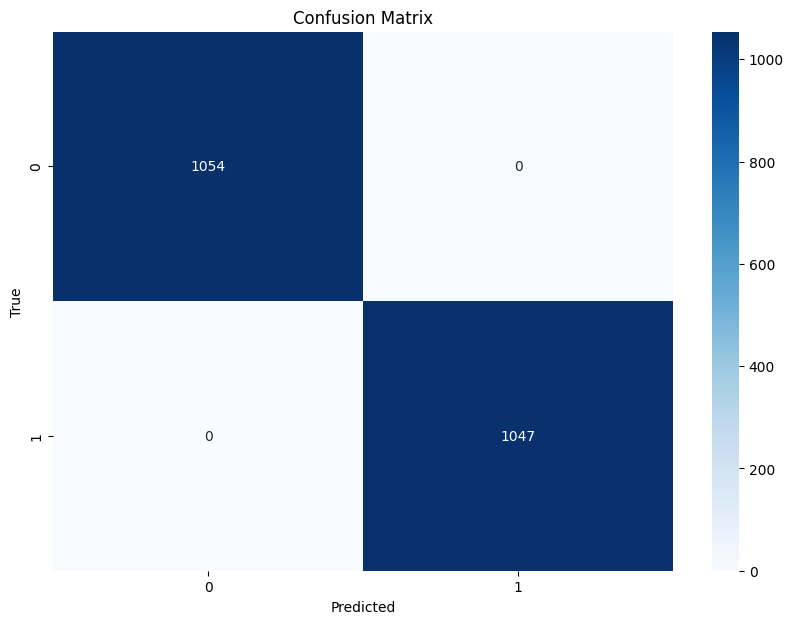

In [13]:
#evaluation of the model's performance on the testing data
# set the model to evaluation mode to disable dropout and other training-specific layers
transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

    # Convert output to probabilities and get predictions
    test_probs = torch.sigmoid(test_output) #converts logits output by model into probabilities
    test_preds = torch.argmax(test_probs, dim=-1).squeeze() #get the predicted class by finding the index with the maximum probability

    # Calculate metrics using sklearn.metrics
    accuracy = metrics.accuracy_score(flag_test, test_preds)
    precision = metrics.precision_score(flag_test, test_preds)
    recall = metrics.recall_score(flag_test, test_preds)
    f1_score = metrics.f1_score(flag_test, test_preds) #useful for imbalanced datasets
    # harmonic mean of precision and recall (1=best, 0=worst)
    conf_matrix = confusion_matrix(flag_test, test_preds)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Visualize the results by plotting heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

This transformer gives 100% accuracy, precision, recall and f-measure, making it a very good model since every prediction is correct (see: [this page](https://en.wikipedia.org/wiki/Precision_and_recall) for mathematical definitions of each statistic).

We also plot the loss over each epoch below in order to visualize better the model's performance and data distribution.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[0.31801703572273254, 0.15955133736133575, 0.0801057517528534]
[10, 20, 30]


Text(0, 0.5, 'Training loss')

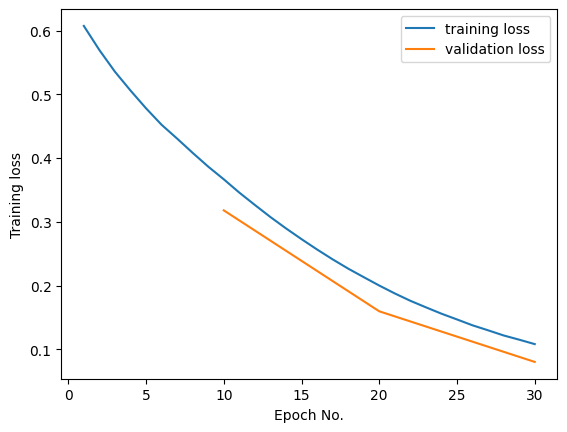

In [14]:
#plot loss as a function of epoch
epoch_range=np.arange(1,epoch_num+1)
print(epoch_range)

epoch_range2=[10, 20, 30]
print(val_losses)
print(epoch_range2)

plt.plot(epoch_range, train_losses, label = 'training loss')
plt.plot(epoch_range2, val_losses, label = 'validation loss')

plt.legend()
plt.xlabel('Epoch No.')
plt.ylabel('Training loss')

## Innovation: run transformer model on a new dataset

Now, we run the transformer model on our own LIFESim dataset contained in the file _LIFEsim_data.csv_ and compare its performance with that on the previous dataset.

In [17]:
#loading LIFEsim dataset
df = pd.read_csv('LIFEsim_data.csv', index_col=0)
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

#print out the data
df

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,albedo_geom_mir,z,semimajor_p,sep_p,angsep,maxangsep,flux_p,fp,temp_p,radius_s,mass_s,temp_s,distance_s,ra,dec,nuniverse,nstar,stype,id,name_s,lon,lat,s_in,s_out,l_sun,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
0,2.55899,1.21237,6.46922,0.0,0.36825,0.83082,4.28658,0.46104,0.07323,0.11134,0.07928,351.98689,0.02225,0.02225,0.00139,0.00149,1986.80254,0.51902,1823.20348,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,0,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,3.747645,21.85221,True,11.808785,35743.408285,0.0
1,1.62557,95.32925,2.94136,0.0,0.36825,4.71701,0.58424,3.76621,0.17084,0.46161,0.06438,351.98689,0.40843,0.40843,0.02577,0.02736,5.89796,0.50485,413.89362,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,1,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,2.570891,21.85221,True,8.100845,35743.408285,0.0
2,0.64641,413.44526,0.18259,0.0,0.36825,3.59078,0.90651,0.27668,0.54602,0.17279,0.01797,351.98689,1.08622,1.08622,0.06861,0.07277,0.83390,0.16952,218.31895,1.010,1.00,5720.0,14.92631,150.25274,31.92367,0,0,G,2,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,True,0.051327,21.85221,False,0.161731,35743.408285,0.0
3,1.45874,51.20469,5.36760,0.0,2.01016,2.62388,0.47298,2.25944,0.53153,0.47091,0.09864,0.42148,0.26988,0.26988,0.01687,0.01808,13.50798,0.15915,441.44066,1.010,1.00,5720.0,14.92631,150.25274,31.92367,1,0,G,3,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,8.482665,21.85221,True,26.728775,35743.408285,0.0
4,2.03712,98.57858,4.45356,0.0,2.01016,1.71757,2.04617,2.98199,0.32327,0.59087,0.05960,0.42148,0.41766,0.41766,0.01427,0.02798,5.64018,0.87606,389.02824,1.010,1.00,5720.0,14.92631,150.25274,31.92367,1,0,G,4,NaN,2.460927,0.323238,1.758501,0.320812,0.978398,0.745910,1.746354,1.246132,False,7.213424,21.85221,True,22.729412,35743.408285,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0.82089,48.64809,3.00300,0.0,1.36699,3.29171,5.84907,1.15447,0.47915,0.40514,0.07304,0.10537,0.14727,0.14727,0.01173,0.01536,0.22655,0.06440,163.12614,0.243,0.18,3100.0,9.58606,306.52209,58.57297,7,1718,M,45537,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.286335,100.00000,False,0.000000,0.000000,-36000.0
14000,0.76631,3.78368,0.47407,0.0,2.15206,1.81751,2.27749,6.06507,0.36787,0.07721,0.00894,218.62589,0.02683,0.02683,0.00189,0.00280,6.82394,0.04080,401.11076,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45538,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,1.669327,100.00000,False,0.000000,0.000000,-36000.0
14001,1.29841,30.83798,1.36537,0.0,2.15206,5.07573,5.95634,4.86269,0.54785,0.21281,0.09392,218.62589,0.10867,0.10867,0.00644,0.01134,0.41604,0.84537,183.29836,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45539,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,True,0.552908,100.00000,False,0.000000,0.000000,-36000.0
14002,1.31487,184.70674,1.57873,0.0,2.15206,4.52980,5.85123,2.65320,0.54567,0.19618,0.09322,218.62589,0.35841,0.35841,0.02792,0.03739,0.03825,0.05919,101.05305,0.243,0.18,3100.0,9.58606,306.52209,58.57297,9,1718,M,45540,NaN,6.139112,1.251858,1.495789,0.212898,0.004886,0.057153,0.151491,0.104322,False,0.024031,100.00000,False,0.000000,0.000000,-36000.0


In [18]:
#preprocessing the data

#drop irrelevant columns
df.drop('name_s', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('nuniverse', axis=1, inplace=True)

scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]
#check intermediate outputs
print(min_max_df)

     radius_p  p_orb  mass_p  ecc_p  inc_p  large_omega_p  small_omega_p  theta_p  albedo_bond  albedo_geom_vis  albedo_geom_mir      z  semimajor_p  sep_p  angsep  maxangsep  flux_p     fp  temp_p  radius_s  mass_s  temp_s  distance_s     ra    dec  nstar    lon    lat   s_in  s_out  l_sun  hz_in  hz_out  hz_center  habitable  snr_1h  baseline  detected  snr_current  int_time  t_slew  stype_F  stype_G  stype_K  stype_M
Min         0      0       0      0      0              0              0        0            0                0                0      0            0      0       0          0       0      0       0         0       0       0           0      0      0      0      0      0      0      0      0      0       0          0          0       0         0         0            0         0       0        0        0        0        0
Max     20000  20000   20000      0  19999          19999          20000    20000        20000            20000            20000  20000        20000  20

In [19]:
flag = np.random.randint(0, 2, size=data.shape[0])

#split the data into training and testing sets
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

encoded_data_train = torch.tensor(encoded_data_train.values, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

encoded_data_test = torch.tensor(encoded_data_test.values, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

encoded_data_val = torch.tensor(encoded_data_val.values, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

#set training parameters
src_vocab_size = scaler_number + 1
tgt_vocab_size = 2
d_model = 128
num_heads = 1 # number of transformer heads (the model has 1 head)
num_layers = 2
d_ff = 32
max_seq_length = 48
dropout = 0.1
epoch_num = 30 #evaluates over 30 epochs

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#initialise arrays
train_losses = []
val_losses = []
test_losses = []

#train the model on the training data
transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    #for every 10th epoch, print out validation loss
    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

Epoch: 1, Loss: 0.8029285669326782
Epoch: 2, Loss: 0.7592034935951233
Epoch: 3, Loss: 0.7187308669090271
Epoch: 4, Loss: 0.6847753524780273
Epoch: 5, Loss: 0.6479626297950745
Epoch: 6, Loss: 0.6168262362480164
Epoch: 7, Loss: 0.5847275853157043
Epoch: 8, Loss: 0.5575487613677979
Epoch: 9, Loss: 0.525701105594635
Epoch: 10, Loss: 0.4975835084915161
Validation Loss: 0.4421292543411255
Epoch: 11, Loss: 0.47224661707878113
Epoch: 12, Loss: 0.44522762298583984
Epoch: 13, Loss: 0.42055171728134155
Epoch: 14, Loss: 0.3958694040775299
Epoch: 15, Loss: 0.37328365445137024
Epoch: 16, Loss: 0.3507175147533417
Epoch: 17, Loss: 0.3302757740020752
Epoch: 18, Loss: 0.30956706404685974
Epoch: 19, Loss: 0.2901199162006378
Epoch: 20, Loss: 0.2715053856372833
Validation Loss: 0.2203167825937271
Epoch: 21, Loss: 0.25413647294044495
Epoch: 22, Loss: 0.238033726811409
Epoch: 23, Loss: 0.22165918350219727
Epoch: 24, Loss: 0.20774638652801514
Epoch: 25, Loss: 0.19291254878044128
Epoch: 26, Loss: 0.18042291700

### Analysis of Model Performance

Again, we analyse the model’s performance using appropriate metrics (e.g., accuracy, precision, recall) and visualization of results.

Testing Loss: 0.09855618327856064
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1056    0]
 [   0 1045]]


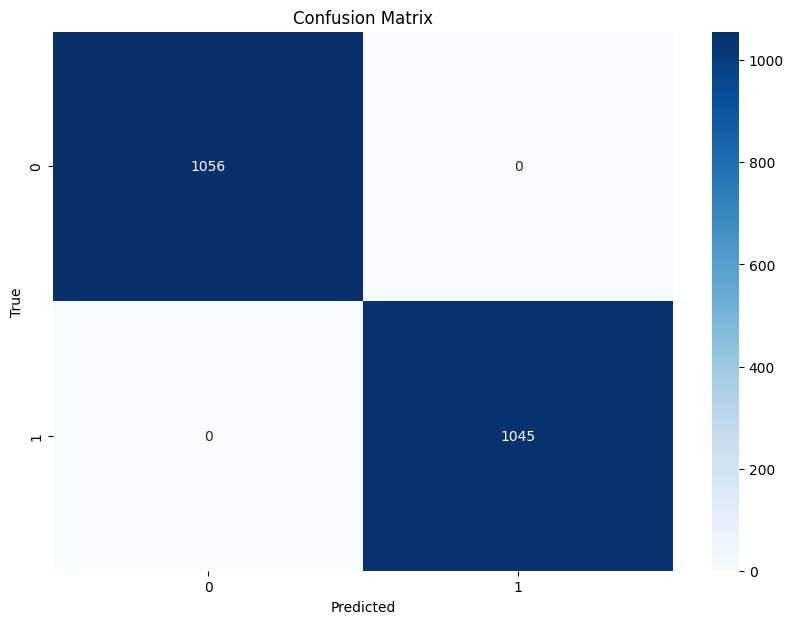

In [20]:
#evaluation of the model's performance on the testing data
# set the model to evaluation mode to disable dropout and other training-specific layers
transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

    # Convert output to probabilities and get predictions
    test_probs = torch.sigmoid(test_output) #converts logits output by model into probabilities
    test_preds = torch.argmax(test_probs, dim=-1).squeeze() #get the predicted class by finding the index with the maximum probability

    # Calculate metrics using sklearn.metrics
    accuracy = metrics.accuracy_score(flag_test, test_preds)
    precision = metrics.precision_score(flag_test, test_preds)
    recall = metrics.recall_score(flag_test, test_preds)
    f1_score = metrics.f1_score(flag_test, test_preds) #useful for imbalanced datasets
    # harmonic mean of precision and recall (1=best, 0=worst)
    conf_matrix = confusion_matrix(flag_test, test_preds)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Visualize the results by plotting heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[0.4421292543411255, 0.2203167825937271, 0.09878053516149521]
[10, 20, 30]


Text(0, 0.5, 'Training loss')

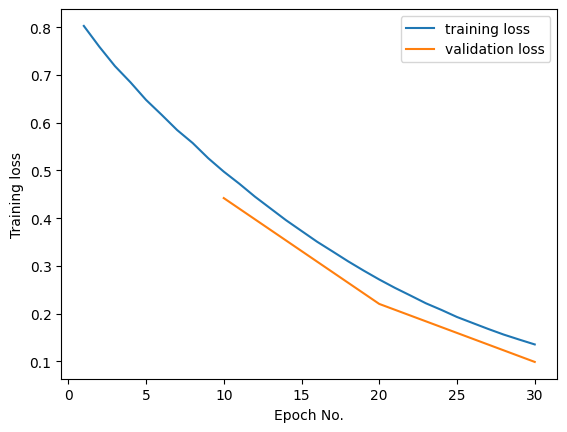

In [21]:
#plot loss as a function of epoch
epoch_range=np.arange(1,epoch_num+1)
print(epoch_range)

epoch_range2=[10, 20, 30]
print(val_losses)
print(epoch_range2)

plt.plot(epoch_range, train_losses, label = 'training loss')
plt.plot(epoch_range2, val_losses, label = 'validation loss')

plt.legend()
plt.xlabel('Epoch No.')
plt.ylabel('Training loss')

The model performs very similarly to before, again giving 100% accuracy, precision, recall and f-measure. This is expected since the datasets are quite similar in nature and format.

## References

- [RNNs and Transformers for Sequence-to-Sequence Modeling by Sebastian Raschka for STAT 453: Intro to Deep Learning](https://drive.google.com/file/d/14zSHd_SMxWI750pj4r9nh18ai2hBTyAA/view)
- [Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). 
Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008)](https://arxiv.org/abs/1706.03762).
- [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)